# Visual Analytics Makeup Assignment: Pipeline with Yellowbrick

#### Process: Create a Jupyter notebook that (1) downloads a new data set from the UCI machine learning repository, (2) loads the data, (3) does a visual exploration of the data using Yellowbrick with accompanying text interpretation, and then (4) fits and visually compares two or more Scikit-Learn models using Yellowbrick, providing text interpretation. 

Sources: Data set used for this assignment is the Forest Fire data set at https://archive.ics.uci.edu/ml/datasets/Forest+Fires. This data set includes ratings from the Canadian Forest Fire Weather Index (FWI) System; definitions from that system are at http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi. 

### Import all the things

In [1]:

import os
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot, AlphaSelection
from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from yellowbrick.features import Rank2D
from pandas.tools.plotting import scatter_matrix
%matplotlib inline


# Ignore warnings in the Notebook
import warnings
warnings.filterwarnings('ignore')

### 1) Download data set from UCI

In [2]:
data_url = ('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

def download_data(url, path='forest-fires'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)
        
download_data(data_url)

### 2) Load the data

In [3]:
data = pd.read_csv('forest-fires/forestfires.csv')

In [4]:
data.columns = ['x_coord', 'y_coord', 'month', 'day','kindling', 'ground_moisture', 'drought_code',
    'initial_spread', 'temp_C', 'relative_humid', 'wind_km/h', 'rain_mm_m2','burn_area']

In [5]:
data.head()

,x_coord,y_coord,month,day,kindling,ground_moisture,drought_code,initial_spread,temp_C,relative_humid,wind_km/h,rain_mm_m2,burn_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Super clean data. Thanks UCI guys! 

In [6]:
data.describe()

,x_coord,y_coord,kindling,ground_moisture,drought_code,initial_spread,temp_C,relative_humid,wind_km/h,rain_mm_m2,burn_area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### 3 Visual exploration

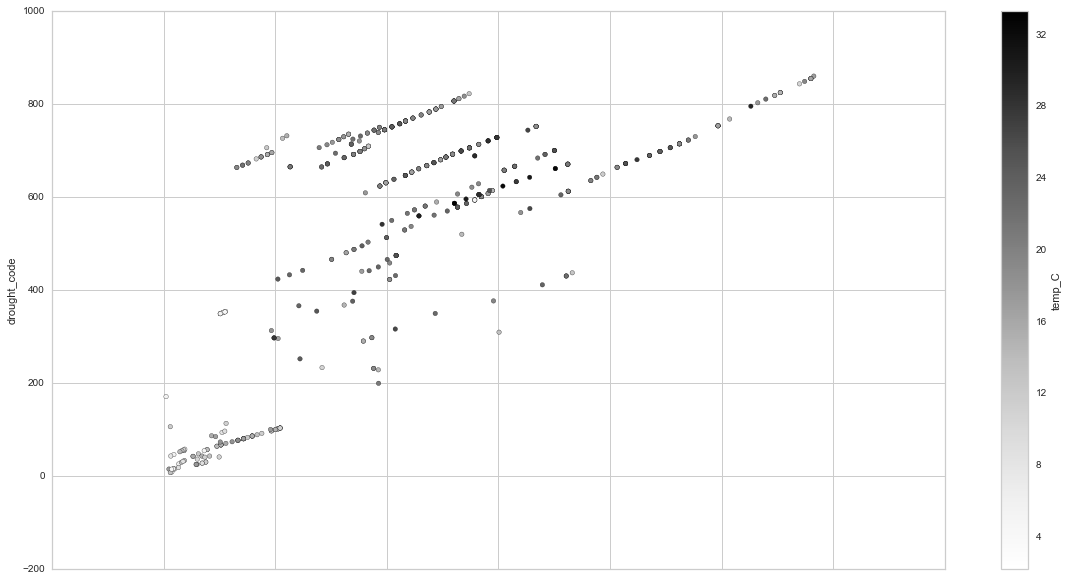

In [7]:
data.plot(kind='scatter', x='ground_moisture', y='drought_code', c='temp_C',figsize=[20,10])

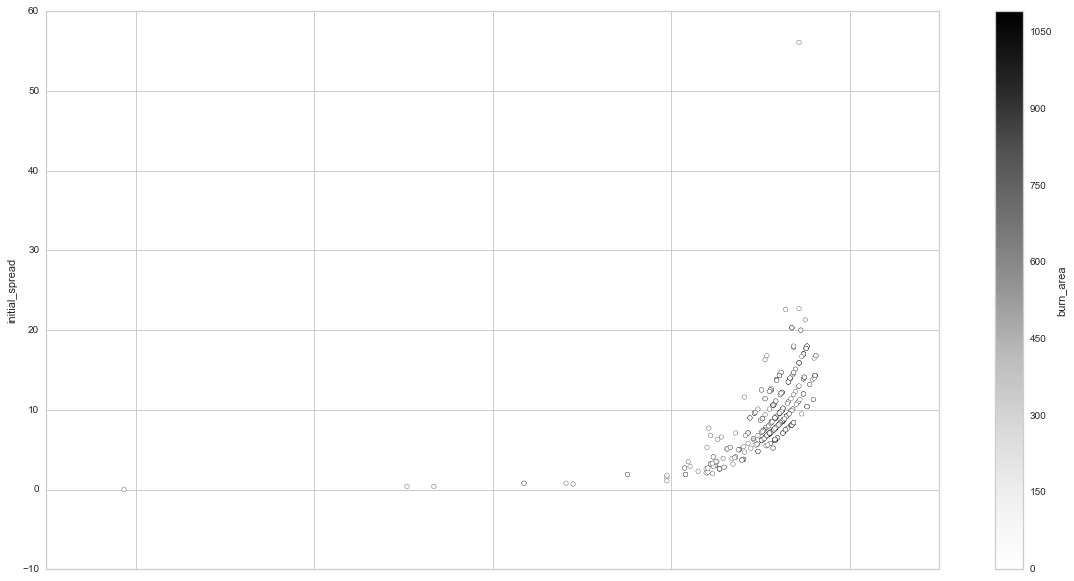

In [8]:
data.plot(kind='scatter', x='kindling', y='initial_spread', c='burn_area',figsize=[20,10])

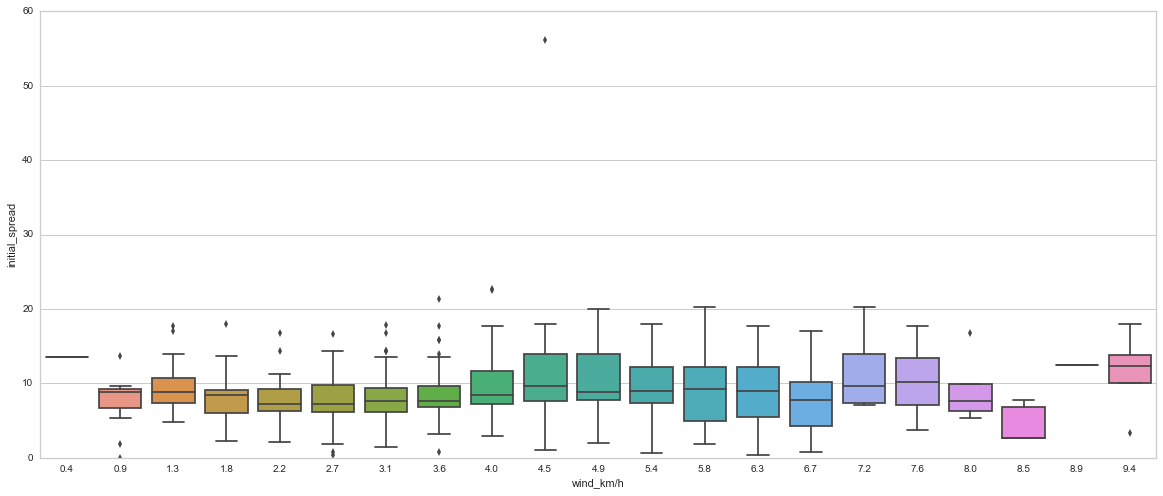

In [9]:
plt.figure(figsize=(20, 8))
sns.boxplot(x = "wind_km/h", y = "initial_spread", data = data)

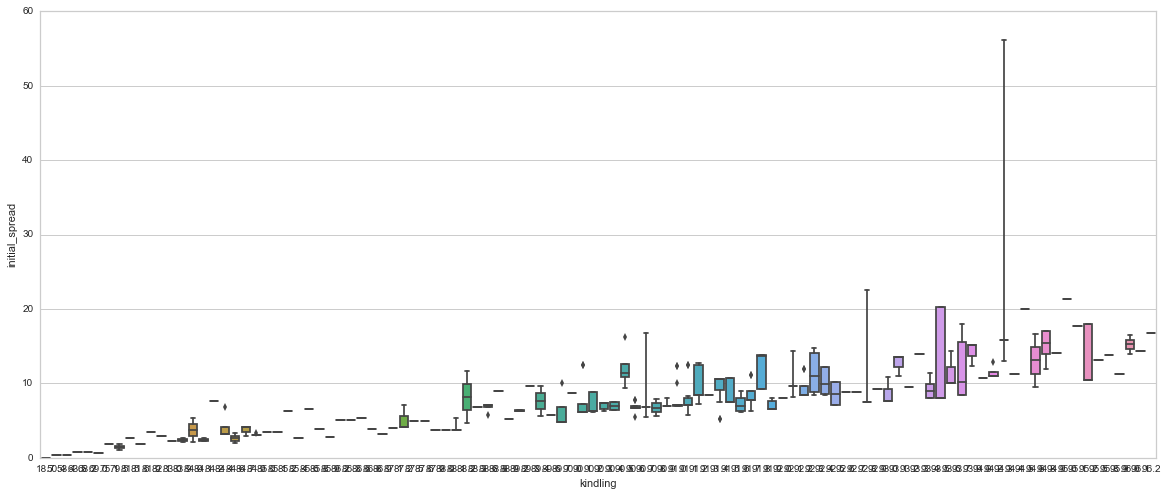

In [10]:
plt.figure(figsize=(20, 8))
sns.boxplot(x = "kindling", y = "initial_spread", data = data)

I'm going to go ahead and drop the month/day out of here for machine learning now because I already have data on the temperature/ground moisture/wind on the actual day of the forest fires. Knowing that a fire started on a Friday in March isn't really helpful. If the park where this data came from is anything like DC it could be snowing one day and on fire the next (literally and figuratively in this case... ). 

In [11]:
outcome = data.burn_area

In [12]:
columns_to_remove = ["month", "day"]
cols = [col for col in data.columns if col not in columns_to_remove]
data_ml = data[cols]
del(columns_to_remove, cols)

In [ ]:
Train, test, split -- GO!

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_ml, outcome, 
                                                        test_size=0.33, random_state=42)

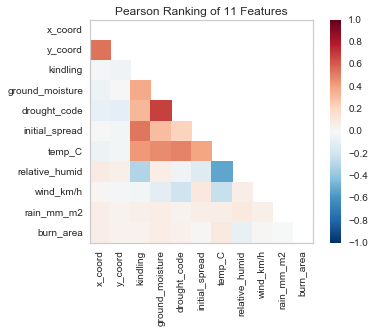

In [14]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(data_ml)
visualizer.poof()

Poof! Pearson visualization shows a few correlated features... like temperature, which obviously you'd expect with *fire*. 

Likewise, Drought Code (DC) and ground-moisture (DMC in the original dataset) are correlated because ground-moisture is a rating of the average moisture content of compact organic layers of moderate depth, and DC is the average moisture of deep layers, which is an indicator of seasonal drought effects. And kindling (FFMC in the original dataset stands for Fine Fuel Moisture Code, which is a rating of the moisture content of litter/debris/kindling-type fuels) is an indicator of the ease of ignition, so you'd expect a strong correlation between kindling and the initial spread.  

### 4) Fit and visually compare some models

#### 4.1: Linear Model -- Linear Regression

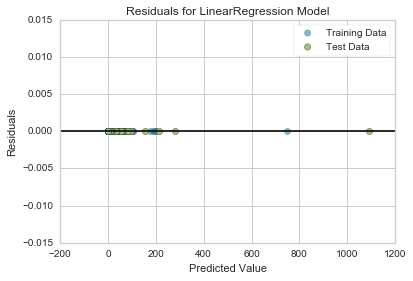

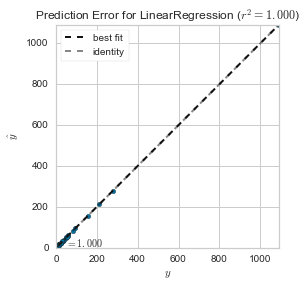

In [15]:
# Fit Model
LinRegr = LinearRegression()
LinRegr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(LinRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(LinRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

#### 4.2: Linear Model -- ElasticNet Regression

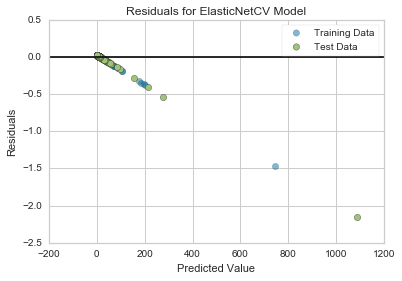

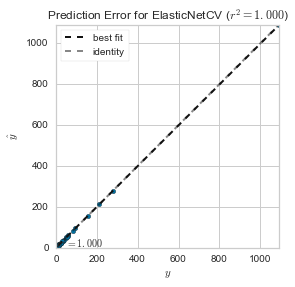

In [16]:
#Fit the model
ElasticNetRegr = ElasticNetCV()
ElasticNetRegr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(ElasticNetRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(ElasticNetRegr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

#### 4.3: SVM Model -- SVR Regression

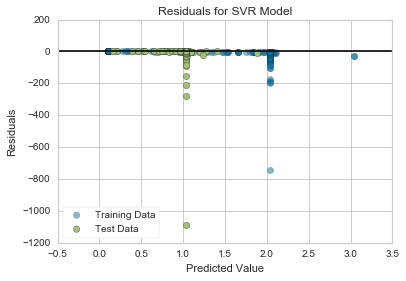

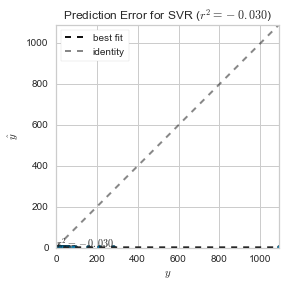

In [17]:
# Fit Model
SVR_Regr = SVR()
SVR_Regr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(SVR_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(SVR_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
#### 4.4: Ensemble Model -- Gradient Boosting

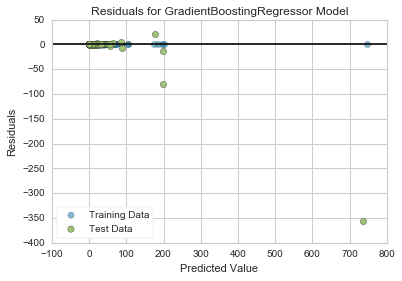

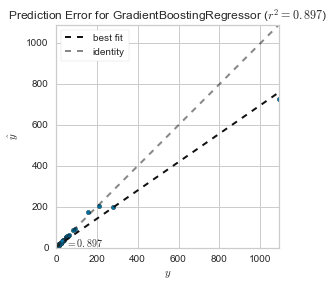

In [18]:
# Fit Model
GradBoost_Regr = GradientBoostingRegressor()
GradBoost_Regr.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(GradBoost_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(GradBoost_Regr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

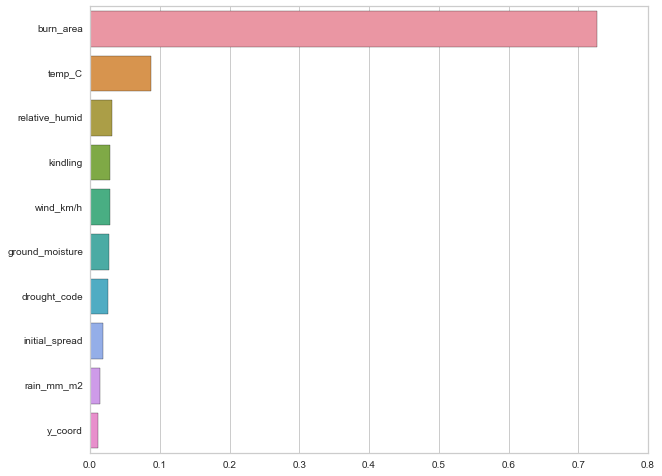

In [19]:
importances = GradBoost_Regr.feature_importances_
Top10 = np.argsort(importances)[::-1][0:10]
Top10_Features = X_train.columns[Top10]
Top10_Importances = importances[Top10]
Top10_Importances
plt.figure(figsize=(10, 8))
sns.barplot(x = Top10_Importances, y = Top10_Features)

#### 4.5: Ensemble Model -- Random Forest Regression

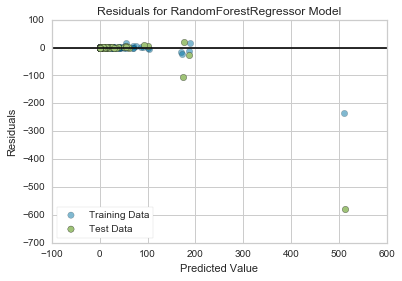

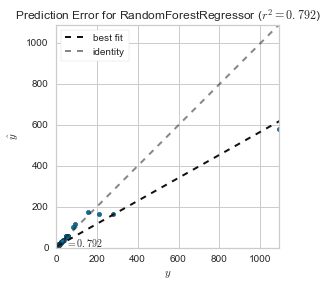

In [21]:
# Fit Model
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

# Visualization 1 - Residual Plot
visualizer = ResidualsPlot(RF)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Visualization 2 - Prediction Error Plot
visualizer = PredictionError(RF)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

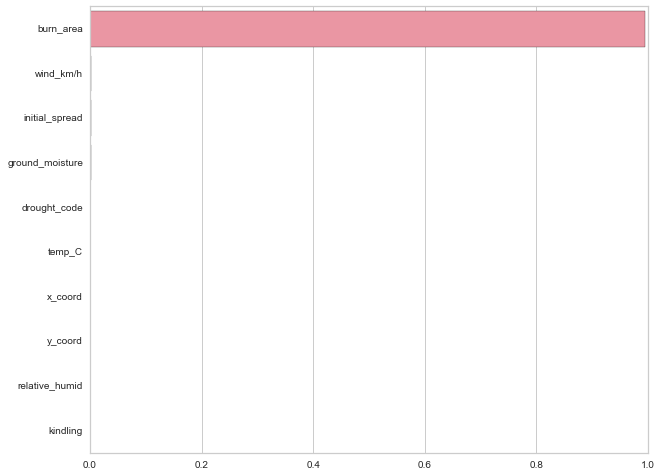

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

importances = RF.feature_importances_
Top10 = np.argsort(importances)[::-1][0:10]
Top10_Features = X_train.columns[Top10]
Top10_Importances = importances[Top10]
Top10_Importances
plt.figure(figsize=(10, 8))
sns.barplot(x = Top10_Importances, y = Top10_Features)

### Conclusion

I looked up the relevant paper at http://www3.dsi.uminho.pt/pcortez/fires.pdf after I finished this assignment and skimmed it, and now realize it was stupid to drop month & day because, as they wrote, "Average monthly weather conditions are quite distinct, while the day of the week could also influence forest fires (e.g. work days vs weekend) since most fires have a human cause." I completely forgot about the human factor... this is why we're not supposed to drop data!!

The researchers focused on SVM and RF, so I'm glad we were on the same page about that, though it looks like SVR actually has the lowest r2 value and train & test don't seem to fit together, so I'm thinking without the month & day data this model ends up being underfit or overfit. Linear has the highest r2 values, and a high degree of homoscedasticity. The ensemble models, GradBoost and RF, had the next highest r2 values, and looks like there might be the tiniest bent toward heteroskedasticity. Looking at feature importance, burn_area was the top by far. 
